In [58]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)

logger = logging.getLogger(__name__)

In [59]:
import random

from arc_dsl import show_grids
from arc_dsl.solve import _make_env
from arc_dsl.interpreter import eval_sentence
from arc_dsl.data import get_task

## Solve an ARC task

In [60]:
from arc_dsl.solve import solve_task

task = get_task("ea32f347")

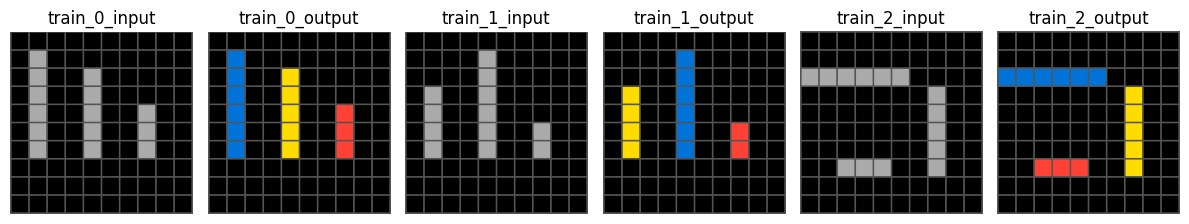

In [61]:
# Training examples
show_grids(train_0_input=task.train[0].input, train_0_output=task.train[0].output,
           train_1_input=task.train[1].input, train_1_output=task.train[1].output,
           train_2_input=task.train[2].input, train_2_output=task.train[2].output,)

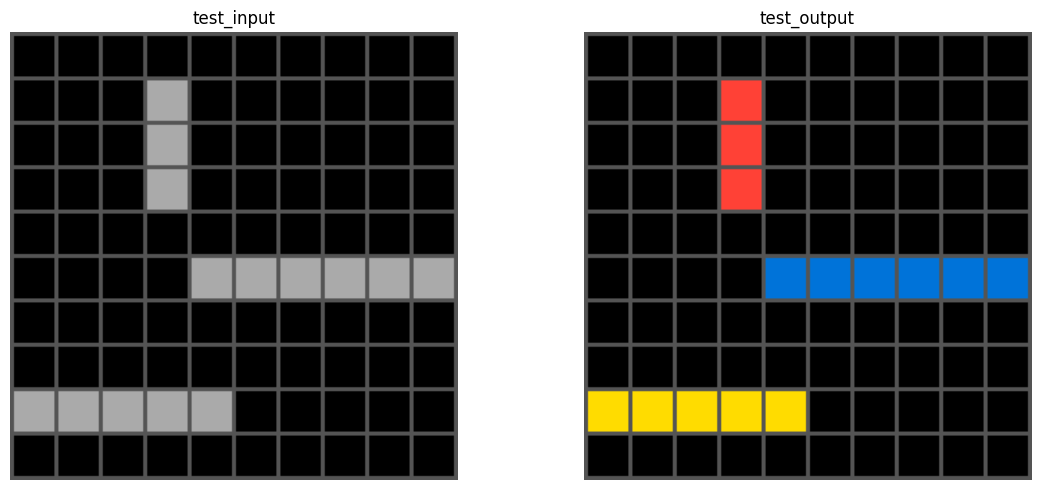

In [62]:
# Test examples
show_grids(test_input=task.test[0].input, test_output=task.test[0].output,)

In [63]:
# Decomposes and finds a solution for all task examples. Then returns 2 solutions for the test grids.
solutions = solve_task(task, n_tries=3)

11:20:32 - INFO - Attempting to solve task ea32f347..
11:20:49 - INFO - Attempt no 1..
11:20:49 - INFO - Enumerated 12.2 thousand forms.
11:20:49 - INFO - Found explicit solution!
11:20:49 - INFO - Solution solved 4/4 train examples.


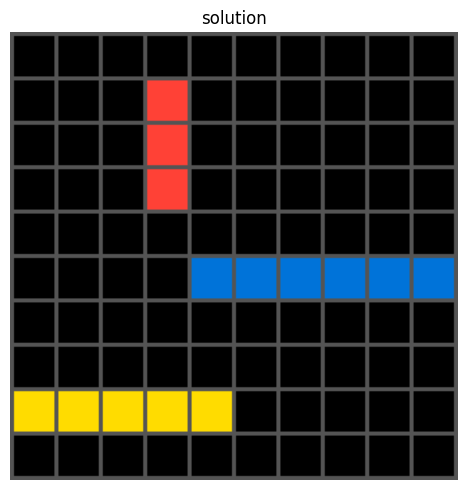

In [64]:
if solutions is not None:
    show_grids(solution=solutions[0][0])
else:
    print("No solution found")

## Detailed walkthrough of a single ARC example grid

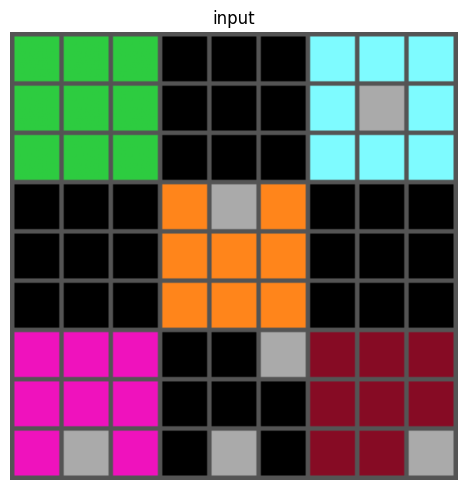

In [65]:
task = get_task("5614dbcf")
example = task.train[0]

# The input grid
show_grids(input=example.input)

In [66]:
from arc_dsl.models.decomposition.model import DecompositionModel

decomposition_model = DecompositionModel()

# Run the decomposition model on the input grid
decomposed_grid = decomposition_model.decompose(example.input)

/home/jelen/code/abzu/arc-dsl/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'positional_grid_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/jelen/code/abzu/arc-dsl/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/jelen/code/abzu/arc-dsl/venv/lib/python3.12/site-packages/keras/src/layers

In [67]:
# Decompsition of the input grid into DSL representation of the individual objects
print(decomposed_grid.to_dsl())

(MAKE-GRID 9 9
    (MAKE-BITMAP 6 6 3 3 BROWN 15 15 0)
    (MAKE-BITMAP 8 1 1 1 GREY 8)
    (MAKE-BITMAP 6 0 3 3 FUCHSIA 15 14 8)
    (MAKE-BITMAP 0 6 3 3 TEAL 15 7 8)
    (MAKE-BITMAP 3 3 3 3 ORANGE 11 15 8)
    (MAKE-BITMAP 8 4 1 1 GREY 8)
    (MAKE-BITMAP 3 4 1 1 GREY 8)
    (MAKE-BITMAP 0 0 3 3 GREEN 15 15 8)
    (MAKE-BITMAP 6 5 1 1 GREY 8)
    (MAKE-BITMAP 8 8 1 1 GREY 8)
    (MAKE-BITMAP 1 7 1 1 GREY 8)
    (MAKE-BITMAP 3 4 1 1 GREY 8))


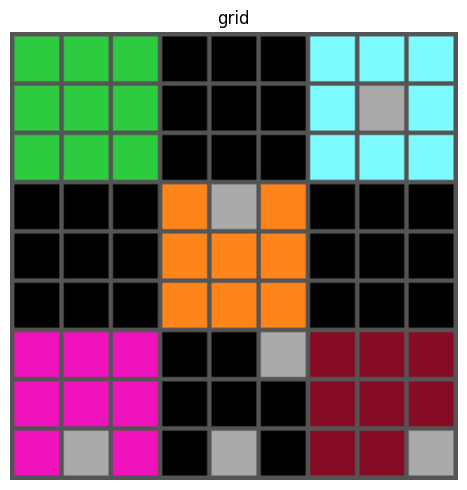

In [68]:
# The decomposition should match the input grid
show_grids(grid=decomposed_grid.draw())

In [69]:
ideas = """
;; Define filter function, return true/false
(setparam var1
    (lambda (var1)
        (!= (get-bitmap-color var1) GREY)))

;; Filter out non-grey bitmaps
(setparam var2
    (filter var1 (get-grid-bitmaps decomposition)))

;; Create new bitmap
(setparam var3
    (lambda (var1)
        (make-bitmap
            (/ (get-bitmap-x var1) 3)
            (/ (get-bitmap-y var1) 3)
            1
            1
            (get-bitmap-color var1)
            8
            )))
"""

# Add the decomposition and these hardcoded ideas to the environment
env = _make_env(decomposed_grid, ideas)

In [70]:
from arc_dsl.search.patterns import resolve_patterns
from arc_dsl.search.enumerate import enumerate_forms

patterns = resolve_patterns(env)
all_forms = enumerate_forms(
    patterns,
    max_depth=3,
    expected_type=list
)

In [71]:
random.choice(all_forms)

['SORT', 'SET-BITMAP-Y', ['MAP', 'GET-GRID-BITMAPS', 'VAR2']]

In [72]:
from arc_dsl.search import search_random_pop

# Search for a program that transforms the decompostion into the output grid
grid_transform, acc = search_random_pop(all_forms, env, grid_true=example.output, rng=random.Random(11))

print(f"{acc=}")
print(f"{grid_transform=}")

acc=1.0
grid_transform='(APPLY MAKE-GRID 3 3 (MAP VAR3 VAR2))'


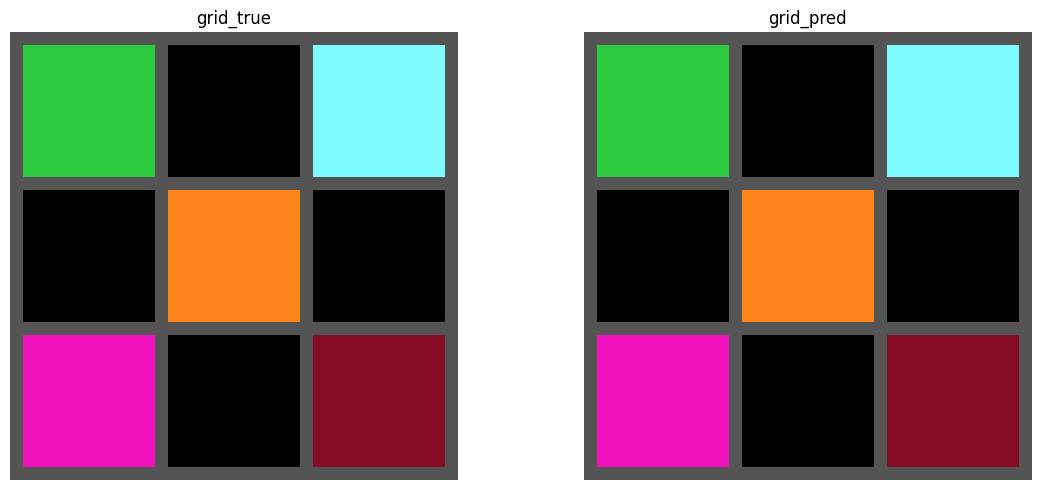

In [73]:
predicted_grid = eval_sentence(ideas + grid_transform, env=dict(env))
show_grids(grid_true=example.output, grid_pred=predicted_grid.draw())